# 1. importation des librairies et preparation des données

## 1.1 importation des librairies

In [1397]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import seaborn as sns
import math
import plotly.express as px
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn import decomposition, preprocessing, metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

In [1398]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

## 1.2 importation des dataframes

In [1399]:
dispo = pd.read_csv('./sources/DisponibiliteAlimentaire_2017.csv')
pop = pd.read_csv('./sources/Population_2000_2018.csv')
pib = pd.read_csv('./sources/pib.csv')
stab = pd.read_csv('./sources/stabilite.csv')
iso3 = pd.read_csv('./sources/countries-codes.csv', sep=';')

## 1.3 preparation des dataframes

### 1.3.1 preparation des fichiers de disponibilité alimentaire

In [1400]:
poultry = dispo[dispo['Code Produit']==2734]
poultry.nunique()
poultry = pd.pivot(data=poultry, index='Zone', columns=['Élément'], values=['Valeur'])
poultry = poultry.Valeur[['Importations - Quantité', 'Disponibilité intérieure', 'Disponibilité de protéines en quantité (g/personne/jour)']]
complete = poultry
complete['Ratio importation / disponibilité interieure'] = complete['Importations - Quantité'] / complete['Disponibilité intérieure']
complete = complete.rename(columns={'Importations - Quantité':'Importations', 
'Disponibilité de protéines en quantité (g/personne/jour)':'Disponibilité de protéines (g/personne/jour)'})
complete = complete.dropna()
complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170 entries, Afghanistan to Îles Salomon
Data columns (total 4 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Importations                                  170 non-null    float64
 1   Disponibilité intérieure                      170 non-null    float64
 2   Disponibilité de protéines (g/personne/jour)  170 non-null    float64
 3   Ratio importation / disponibilité interieure  170 non-null    float64
dtypes: float64(4)
memory usage: 6.6+ KB


### 1.3.2 preparation du fichier de population

In [1401]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            4411 non-null   object 
 1   Domaine                 4411 non-null   object 
 2   Code zone               4411 non-null   int64  
 3   Zone                    4411 non-null   object 
 4   Code Élément            4411 non-null   int64  
 5   Élément                 4411 non-null   object 
 6   Code Produit            4411 non-null   int64  
 7   Produit                 4411 non-null   object 
 8   Code année              4411 non-null   int64  
 9   Année                   4411 non-null   int64  
 10  Unité                   4411 non-null   object 
 11  Valeur                  4411 non-null   float64
 12  Symbole                 4411 non-null   object 
 13  Description du Symbole  4411 non-null   object 
 14  Note                    258 non-null    

In [1402]:
pop_past = pop[pop['Année']==2013]
pop = pop[pop['Année']==2017]
pop_past = pop_past.pivot_table(values='Valeur', index='Zone', columns=['Année'])
pop = pop.pivot_table(values='Valeur', index='Zone', columns=['Année'])
pop = pd.merge(pop, pop_past, on='Zone', how='inner')
pop['Pop_evo'] = (pop[2017] - pop[2013]) / pop[2013]
pop = pop.drop(2013, axis=1)
pop[2017] = pop[2017] * 1000
pop = pop.rename(columns={2017: "Population"}).reset_index(inplace=False)
pop.index.name = None


In [1403]:
pop = pop.rename(columns={"Valeur": "Population"})
complete = pd.merge(complete, pop, on='Zone', how='inner')
complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Zone                                          170 non-null    object 
 1   Importations                                  170 non-null    float64
 2   Disponibilité intérieure                      170 non-null    float64
 3   Disponibilité de protéines (g/personne/jour)  170 non-null    float64
 4   Ratio importation / disponibilité interieure  170 non-null    float64
 5   Population                                    170 non-null    float64
 6   Pop_evo                                       170 non-null    float64
dtypes: float64(6), object(1)
memory usage: 10.6+ KB


### 1.3.3 preparation du fichier PIB

In [1404]:
pib = pib[['Zone', 'Année', 'Valeur']]
pib = pib.pivot_table(values='Valeur', index='Zone', columns=['Année'])
pib['evo'] = (pib[2017] - pib[2013]) / pib[2013]
pib = pib[[2017, 'evo']]
complete = pd.merge(complete, pib, on='Zone', how='left')
complete = complete.rename(columns={2017: "PIB/habitant", 'evo':'PIB_evo'})
complete.info()
display(complete[complete['PIB/habitant'].isna()])
complete = complete.dropna(axis=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Zone                                          170 non-null    object 
 1   Importations                                  170 non-null    float64
 2   Disponibilité intérieure                      170 non-null    float64
 3   Disponibilité de protéines (g/personne/jour)  170 non-null    float64
 4   Ratio importation / disponibilité interieure  170 non-null    float64
 5   Population                                    170 non-null    float64
 6   Pop_evo                                       170 non-null    float64
 7   PIB/habitant                                  163 non-null    float64
 8   PIB_evo                                       163 non-null    float64
dtypes: float64(8), object(1)
memory usage: 13.3+ KB


,Zone,Importations,Disponibilité intérieure,Disponibilité de protéines (g/personne/jour),Ratio importation / disponibilité interieure,Population,Pop_evo,PIB/habitant,PIB_evo
33,"Chine, Taiwan Province de",161.0,785.0,11.01,0.205096,23674546.0,0.010800,NaN,NaN
40,Cuba,312.0,342.0,7.12,0.912281,11339254.0,0.005010,NaN,NaN
108,Nouvelle-Calédonie,9.0,11.0,14.05,0.818182,277150.0,0.048849,NaN,NaN
119,Polynésie française,15.0,15.0,16.20,1.000000,276102.0,0.021359,NaN,NaN
129,République populaire démocratique de Corée,0.0,43.0,0.49,0.000000,25429825.0,0.020070,NaN,NaN
159,Venezuela (République bolivarienne du),25.0,626.0,7.23,0.039936,29402484.0,-0.012711,NaN,NaN
161,Yémen,78.0,246.0,3.04,0.317073,27834819.0,0.106879,NaN,NaN


### 1.3.4 preparation du fichier stabilite politique

In [1405]:

stab_2017 = stab[stab['Année']==2017]
stab_2017 = stab_2017[['Zone', 'Valeur']]
stab_2017 = stab_2017.rename(columns={'Valeur': 2017})
stab_proper = stab_2017.rename(columns={2017:'Indice stabilité politique'})
complete = pd.merge(complete, stab_proper, on='Zone', how='inner')
complete = complete.drop(index=48, axis=0)
complete.info()
complete.to_csv("./sources/complete.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 161
Data columns (total 10 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Zone                                          161 non-null    object 
 1   Importations                                  161 non-null    float64
 2   Disponibilité intérieure                      161 non-null    float64
 3   Disponibilité de protéines (g/personne/jour)  161 non-null    float64
 4   Ratio importation / disponibilité interieure  161 non-null    float64
 5   Population                                    161 non-null    float64
 6   Pop_evo                                       161 non-null    float64
 7   PIB/habitant                                  161 non-null    float64
 8   PIB_evo                                       161 non-null    float64
 9   Indice stabilité politique                    161 non-null    flo

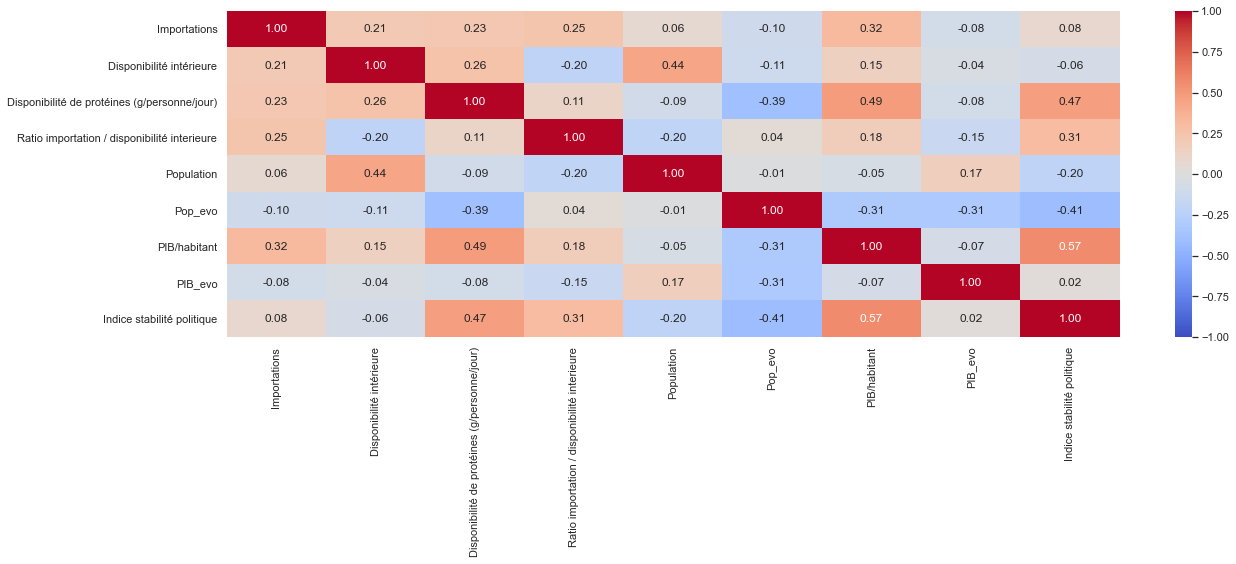

In [1406]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(complete.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm", fmt="0.2f")
plt.show()


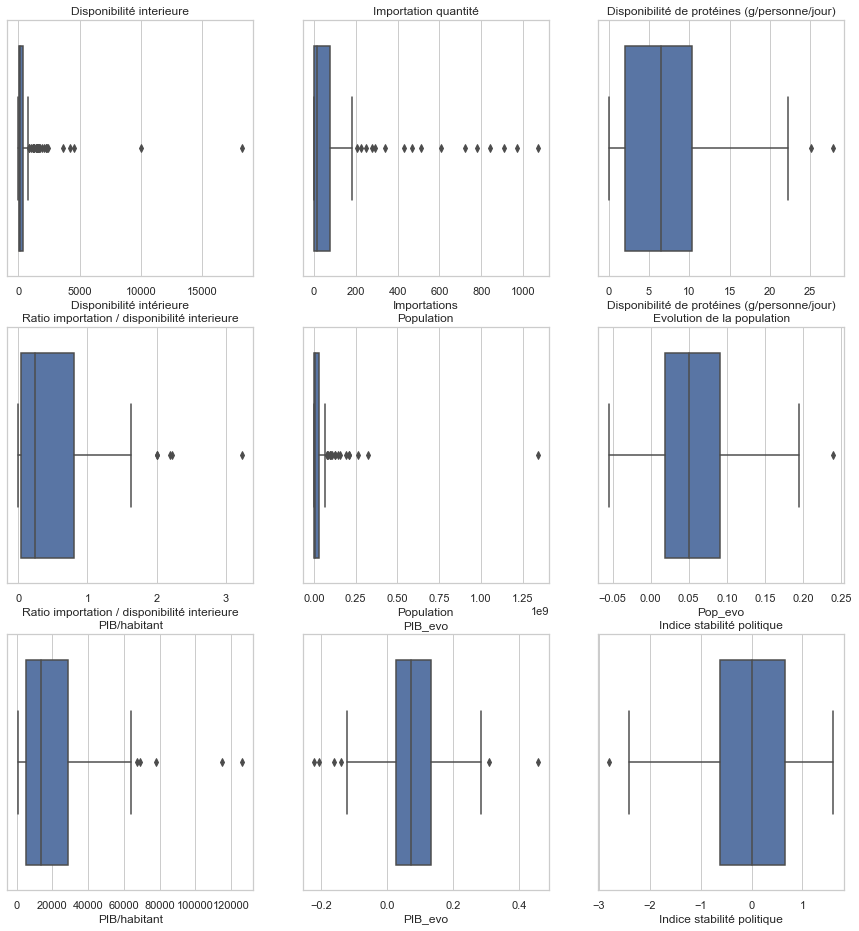

In [1407]:
plt.figure(figsize=(15, 16))
sns.set(style="whitegrid")

plt.subplot(331)
sns.boxplot(data=complete, x='Disponibilité intérieure')
plt.title('Disponibilité interieure')

plt.subplot(332)
sns.boxplot(data=complete, x='Importations')
plt.title('Importation quantité')

plt.subplot(333)
sns.boxplot(data=complete, x='Disponibilité de protéines (g/personne/jour)')
plt.title('Disponibilité de protéines (g/personne/jour)')

plt.subplot(334)
sns.boxplot(data=complete, x='Ratio importation / disponibilité interieure')
plt.title('Ratio importation / disponibilité interieure')

plt.subplot(335)
sns.boxplot(data=complete, x='Population')
plt.title('Population')

plt.subplot(336)
sns.boxplot(data=complete, x='Pop_evo')
plt.title('Evolution de la population')

plt.subplot(337)
sns.boxplot(data=complete, x='PIB/habitant')
plt.title('PIB/habitant')

plt.subplot(338)
sns.boxplot(data=complete, x='PIB_evo')
plt.title('PIB_evo')

plt.subplot(339)
sns.boxplot(data=complete, x='Indice stabilité politique')
plt.title('Indice stabilité politique')

plt.show()